In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

print('Libraries imported.')

Libraries imported.


In [ ]:
# Training constants
BATCH_SIZE = 32
N_EPOCH = 120
N_CLASSES = 10
VERBOSE = 1
VALIDATION_SPLIT = 0.2

print('Main variables initialised.')

Main variables initialised.


In [3]:
# STL-10 is a set of 13k images 96x96 pixels on 3 channels
IMG_CHANNELS = 3
IMG_ROWS = 96
IMG_COLS = 96

print('Image variables initialisation')

Image variables initialisation


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform)
testset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transform)

# trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

Files already downloaded and verified


In [5]:
# Define data augmentation transformations using torchvision
# This creates a composition of multiple image transformations that will be applied sequentially
aug_transform = transforms.Compose([
    # Randomly flip images horizontally with 0.5 probability
    transforms.RandomHorizontalFlip(),

    # Randomly rotate images by up to 40 degrees
    transforms.RandomRotation(40),

    transforms.RandomCrop(96, padding=4),

    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),

    # Convert PIL images to PyTorch tensors
    transforms.ToTensor(),

    # Normalize tensor values to be between -1 and 1
    # Parameters are (mean, std) for each channel
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create augmented training dataset using the transformations defined above
trainset_aug = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=aug_transform)

# Create data loader for the augmented training set
# This handles batching, shuffling and loading the data
trainloader_aug = torch.utils.data.DataLoader(trainset_aug, batch_size=BATCH_SIZE, shuffle=True)

print("Augmenting training set images...")

Files already downloaded and verified
Augmenting training set images...


In [ ]:
# Define a deeper model
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(128 * 12 * 12, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, N_CLASSES)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

print('Deep CNN network defined.')


Deep CNN network defined.


In [9]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, min_delta=0):
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
      score = -val_loss
      if self.best_score is None:
          self.best_score = score
      elif score < self.best_score + self.min_delta:
          self.counter += 1
          if self.verbose:
              print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
          if self.counter >= self.patience:
              self.early_stop = True
      else:
          self.best_score = score
          self.counter = 0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepCNN().to(device)

# Define validation split
dataset_size = len(trainset_aug)
val_size = int(VALIDATION_SPLIT * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset_aug, [train_size, val_size])

# trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True)
# 얼리스탑 객체 생성
early_stopping = EarlyStopping(patience=10, min_delta=1e-4, verbose=True)

# Training function
def train_model():
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(N_EPOCH):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in trainloader_aug:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss, val_correct, val_total = 0.0, 0, 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        history['loss'].append(running_loss / len(trainloader_aug))
        history['val_loss'].append(val_loss / len(valloader))
        scheduler.step(history['val_loss'][-1])
        history['accuracy'].append(correct / total)
        history['val_accuracy'].append(val_correct / val_total)
        print(f"Epoch {epoch+1}/{N_EPOCH}, Loss: {history['loss'][-1]:.4f}, Accuracy: {history['accuracy'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, Val Accuracy: {history['val_accuracy'][-1]:.4f}")
        early_stopping(val_loss)

        if early_stopping.early_stop:
          print("Early stopping")
          break

    print('Training complete.')
    return history

In [11]:
history = train_model()

Epoch 1/120, Loss: 2.1766, Accuracy: 0.1686, Val Loss: 2.0090, Val Accuracy: 0.2640
Epoch 2/120, Loss: 1.9043, Accuracy: 0.2938, Val Loss: 1.7857, Val Accuracy: 0.3230
Epoch 3/120, Loss: 1.7781, Accuracy: 0.3180, Val Loss: 1.6721, Val Accuracy: 0.3780
Epoch 4/120, Loss: 1.7006, Accuracy: 0.3582, Val Loss: 1.6161, Val Accuracy: 0.3970
Epoch 5/120, Loss: 1.6578, Accuracy: 0.3632, Val Loss: 1.5545, Val Accuracy: 0.3950
Epoch 6/120, Loss: 1.6014, Accuracy: 0.3936, Val Loss: 1.5514, Val Accuracy: 0.4230
Epoch 7/120, Loss: 1.5732, Accuracy: 0.3968, Val Loss: 1.4775, Val Accuracy: 0.4610
Epoch 8/120, Loss: 1.5257, Accuracy: 0.4244, Val Loss: 1.4457, Val Accuracy: 0.4740
Epoch 9/120, Loss: 1.5154, Accuracy: 0.4244, Val Loss: 1.4139, Val Accuracy: 0.4750
Epoch 10/120, Loss: 1.5010, Accuracy: 0.4424, Val Loss: 1.3846, Val Accuracy: 0.4970
Epoch 11/120, Loss: 1.4599, Accuracy: 0.4484, Val Loss: 1.3302, Val Accuracy: 0.5110
Epoch 12/120, Loss: 1.4474, Accuracy: 0.4586, Val Loss: 1.3305, Val Accura

In [11]:
# Save model state dictionary
torch.save(model.state_dict(), 'cnn_aug120_model.pth')

# Save entire model
torch.save(model, 'cnn_aug120_model_full.pth')

print('Model and weights saved successfully.')

Model and weights saved successfully.



Test loss: 0.9359
Test accuracy: 67.47%


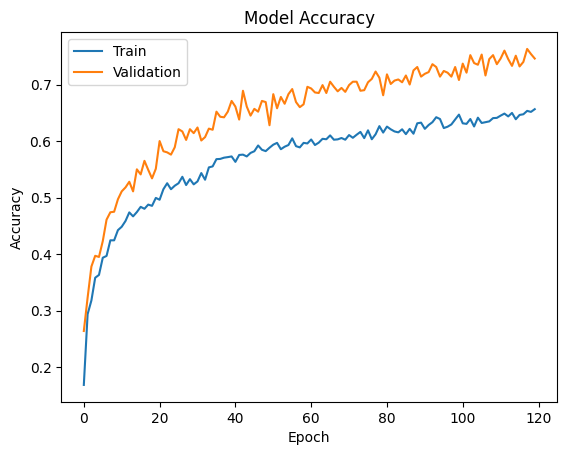

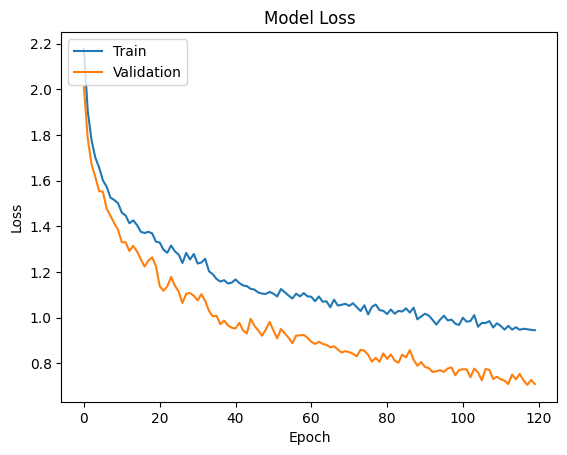

In [12]:
# Testing the model
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(testloader)
test_accuracy = 100. * correct / total

print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.2f}%")

# Plot training history
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
